In [28]:
import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from tqdm.notebook import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

with open('config/config.json', 'r') as file:
    config = json.load(file)
    
rs = config['random_state']

# Data Loading

In [29]:
# df = pd.read_csv(config['ticker_data_close'], index_col=0)

# #print(df.head())
# df_na = df.isna().sum()
# thresh = 0.05 * len(df)
# stocks_to_drop = df_na[df_na > thresh].index.tolist()
# df = df.drop(stocks_to_drop, axis=1)
# df = df.dropna(axis=0)

# df = df.T

# X_data = df.values
# X_train, X_test = train_test_split(X_data, test_size=0.2)
# X_train.shape

In [45]:
df = pd.read_csv(config['ticker_data_preprocessed'], index_col=0)
print(df.shape)

X_data = df.values[:, :-1].astype(float)
y_data = LabelEncoder().fit_transform(df['sector'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, stratify=y_data)
y_train.shape

(482, 1196)


(385,)

In [46]:
# def generate_data_reg(dataset, window=100):
#     list_x = []
#     list_y = []
    
#     for line in dataset:
#         for i in range(0, len(line) - window - 1, window):
#             list_x.append(line[i:i+window])
#             list_y.append(line[i+window])
            
#     return np.vstack(list_x), np.vstack(list_y) 


# window_size=100

# X_train, y_train = generate_data_reg(X_train, window=window_size)
# X_test, y_test = generate_data_reg(X_test, window=window_size)
# y_train, y_test = y_train.flatten(), y_test.flatten()


In [47]:
X_train.shape, y_train.shape

((385, 1195), (385,))

(3850, 100) (970, 100) (3850,) (970,)


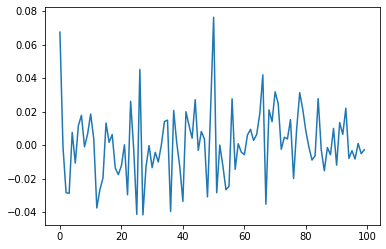

In [64]:
window = 100
len_seq = X_train.shape[1]
n_patches = len_seq//window

X_train = np.vstack([X_train[:, i:i+window] for i in range(n_patches)])
X_test = np.vstack([X_test[:, i:i+window] for i in range(n_patches)])

y_train = np.vstack([y_train.reshape(-1, 1) for i in range(n_patches)]).flatten()
y_test = np.vstack([y_test.reshape(-1, 1) for i in range(n_patches)]).flatten()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

plt.plot(X_train[1])

# NN models

In [97]:
class MyDataset(Dataset):
    def __init__(self, X, y, window=50):
        super().__init__()
        self.X = X
        self.y = y
        self.window=window
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        X = X.reshape([-1, 1])
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return X, y

In [165]:
def train_step(model, loader, criterion, device, optimizer, scheduler=None):
    losses, n_batches = 0, 0
    model.train(True)
    
    y_all_pred = torch.tensor([])
    y_all_true = torch.tensor([])    
    
    for x, labels in loader:

        optimizer.zero_grad()
        x = x.to(device)
        labels = labels.to(device)
        
        y_out = model(x)
        
        loss = criterion(y_out, labels) 
        
        loss.backward()     
        optimizer.step()
        losses += loss
        n_batches += 1
        
        y_all_true = torch.cat((y_all_true, labels.cpu().detach()), dim=0)
        y_all_pred = torch.cat((y_all_pred, y_out.cpu().detach()), dim=0)
        
    y_all_pred = y_all_pred.numpy().reshape([-1, 1])
    y_all_true = y_all_true.numpy().reshape([-1, 1])
    
    #print('train var', np.var(y_all_pred), np.var(y_all_true))

    mean_loss = losses / n_batches

    if scheduler:
        scheduler.step()
    
    return mean_loss

def valid_step(model, loader, criterion, device):
    
    losses, n_batches = 0, 0
    model.eval()    
    
    y_all_pred = torch.tensor([])
    y_all_true = torch.tensor([])   
    
    for x, labels in loader:
        with torch.no_grad():
            x = x.to(device)
            labels = labels.to(device)

            y_out = model(x)
            loss = criterion(y_out, labels)
            losses += loss

            n_batches += 1
        
            y_all_true = torch.cat((y_all_true, labels.cpu().detach()), dim=0)
            y_all_pred = torch.cat((y_all_pred, y_out.cpu().detach()), dim=0)
        
    y_all_pred = y_all_pred.numpy().reshape([-1, 1])
    y_all_true = y_all_true.numpy().reshape([-1, 1])
    
    #print('test var', np.var(y_all_pred), np.var(y_all_true))

    mean_loss = losses / n_batches
    return mean_loss


def calculate_metrics(y_true, y_pred, multiclass=False):
    
    if multiclass:
        average='macro'
    else:
        average='binary'
    
    acc = accuracy_score(y_true, y_pred)
    pr = precision_score(y_true, y_pred, average=average)
    rec = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    return acc, pr, rec, f1
    
def estimate_epoch(loader, model=None, device='cpu', round_=True, multiclass=False):
    
    y_all_pred = torch.tensor([])
    y_all_true = torch.tensor([])
    
    model.eval()   
    
    with torch.no_grad():
        for X, y_true in loader:
            X = X.to(device)
            y_pred = model(X)

            if multiclass:
                y_pred = torch.argmax(y_pred, axis=1)
            else:
                y_pred = torch.round(y_pred)

            y_all_true = torch.cat((y_all_true, y_true.cpu().detach()), dim=0)
            y_all_pred = torch.cat((y_all_pred, y_pred.cpu().detach()), dim=0)
        
    y_all_pred = y_all_pred.numpy().reshape([-1, 1])
    y_all_true = y_all_true.numpy().reshape([-1, 1])
    
    #print(np.unique(y_all_pred))
    
    labels, hist = np.unique(y_all_pred, return_counts=True)
    plt.bar(labels, hist / np.sum(hist))
    plt.show()
    
    acc, pr, rec, f1 = calculate_metrics(y_all_true, y_all_pred, multiclass=multiclass)
    
    return acc, pr, rec, f1
    

def train_procedure(model, train_loader, test_loader, criterion, optimizer, scheduler=None,
                   num_epochs=30, step_print=5):
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = train_step(model, train_loader, criterion, device, optimizer, scheduler)
        test_loss = valid_step(model, test_loader, criterion, device) 
        acc_train, _, _, f1_train = estimate_epoch(train_loader, model, device, multiclass=True)
        acc_test, _, _, f1_test = estimate_epoch(test_loader, model, device, multiclass=True)

        if epoch % step_print == 0:
            #print(f'[Epoch {epoch + 1}] train loss: {train_loss:.5f}; test loss: {test_loss:.5f}')
            print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; acc_train {acc_train:.3f}; f1_train {f1_train:.3f}; test loss: {test_loss:.3f}; acc_test {acc_test:.3f}; f1_test {f1_test:.3f};')
            
    return model


def train_procedure_reg(model, train_loader, test_loader, criterion, optimizer, scheduler=None,
                   num_epochs=30, step_print=5):
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = train_step(model, train_loader, criterion, device, optimizer, scheduler)
        test_loss = valid_step(model, test_loader, criterion, device) 
        

        if epoch % step_print == 0:
            print(f'[Epoch {epoch + 1}] train loss: {train_loss:.5f}; test loss: {test_loss:.5f}')
            #print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; acc_train {acc_train:.3f}; f1_train {f1_train:.3f}; test loss: {test_loss:.3f}; acc_test {acc_test:.3f}; f1_test {f1_test:.3f};')
            
    return model


In [166]:
class LSTM_net(nn.Module):
    def __init__(self, hidden_dim, n_layers, output_dim=1, dropout=0.2):
        super().__init__()
        self.rnn = nn.LSTM(1, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, data):
        
        packed_output, (hidden, cell) = self.rnn(data)
        hidden = hidden.reshape(hidden.shape[1], hidden.shape[2])
        
        hidden = self.dropout(hidden)
        output = self.relu(self.fc1(hidden))
        output = self.fc2(self.dropout(output))            
        return output
    
    def transform(self, data, window):
        pass
    

In [167]:
class Time2Vector(nn.Module):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len
        self.lin = nn.Linear(seq_len, seq_len)
        self.per = nn.Linear(seq_len, seq_len)


    def forward(self, x):
        x_lin = self.lin(x) 
        x_lin = x_lin.unsqueeze(dim=-1) # (batch, seq_len, 1)

        x_per = torch.sin(self.per(x))
        x_per = x_per.unsqueeze(dim=-1) # (batch, seq_len, 1)
        return torch.concat([x_lin, x_per], axis=-1) # (batch, seq_len, 2)

class TransformerEncoder(nn.Module):
    def __init__(self, d_k, d_v, n_heads, ff_dim, seq_len, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout

        self.attn_multi = nn.MultiheadAttention(3, self.n_heads, kdim=self.d_k, vdim=self.d_v )
        self.attn_dropout = nn.Dropout(self.dropout_rate)
        self.attn_normalize = nn.LayerNorm((seq_len, 3), eps=1e-6)

        self.ff_conv1D_1 = nn.Conv1d(3, self.ff_dim, kernel_size=1)
        self.relu = nn.ReLU()
        self.ff_conv1D_2 = nn.Conv1d(self.ff_dim, 1, kernel_size=1) #filters=3, # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
        self.ff_dropout = nn.Dropout(self.dropout_rate)
        self.ff_normalize = nn.LayerNorm((seq_len, 3), eps=1e-6)    

 
    def forward(self, q, k, v): # inputs = (in_seq, in_seq, in_seq)
        
        
        attn_layer, _ = self.attn_multi(q, k, v)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(q + attn_layer)
        
        attn_layer = attn_layer.transpose(2, 1)
        ff_layer = self.relu(self.ff_conv1D_1(attn_layer))
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        
        ff_layer = self.ff_normalize(q + ff_layer.transpose(2, 1))
        return ff_layer 
    
    
class Transformer(nn.Module):
    def __init__(self, d_k, d_v, n_heads, ff_dim, seq_len, dropout=0.1, out_dim=1, **kwargs):
        super(Transformer, self).__init__()
        self.time_embedding = Time2Vector(seq_len)
        self.attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, seq_len)
        self.attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, seq_len)
        self.attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, seq_len)
        self.pooling = nn.AvgPool1d(seq_len)
        
        self.dropout = nn.Dropout(dropout)
        self.lin1 = nn.Linear(3, 64)
        self.lin2 = nn.Linear(64, out_dim)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        time = torch.arange(x.shape[1])
        time = torch.tile(time,(x.shape[0],1)).float().to(device)
        
        in_seq = self.time_embedding(time)
        
        x = torch.concat([in_seq, x], axis=-1)
        x = self.attn_layer1(x, x, x)
        x = self.attn_layer2(x, x, x)
        x = self.attn_layer3(x, x, x)
        
        x = self.dropout(self.pooling(x.transpose(1, 2)))
        x = x.squeeze(-1)
        x = self.dropout(self.relu(self.lin1(x)))
        
        out = self.lin2(x)
        return out

In [168]:
model_id = rs
torch.manual_seed(model_id)

In [169]:
batch_size = 64

train_set = MyDataset(torch.tensor(X_train), torch.tensor(y_train))
test_set = MyDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [170]:
# device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# #device = 'cpu'

# num_epochs = 30
# print(num_epochs)
# LR = 0.0001

# HIDDEN_DIM = 100
# OUTPUT_DIM = 1 #df['sector'].nunique()
# N_LAYERS = 1
# DROPOUT = 0.8

# model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)

# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 12, gamma=0.1)

# model

In [171]:
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

num_epochs = 30
print(num_epochs)
LR = 0.0001

HIDDEN_DIM = 100
OUTPUT_DIM = 1 #df['sector'].nunique()
N_LAYERS = 1
DROPOUT = 0.8

model = Transformer(d_k=3, d_v=3, n_heads=1, ff_dim=100, seq_len=window_size, dropout=0.1, out_dim=11).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 12, gamma=0.1)

model

30


Transformer(
  (time_embedding): Time2Vector(
    (lin): Linear(in_features=100, out_features=100, bias=True)
    (per): Linear(in_features=100, out_features=100, bias=True)
  )
  (attn_layer1): TransformerEncoder(
    (attn_multi): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=3, out_features=3, bias=True)
    )
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (attn_normalize): LayerNorm((100, 3), eps=1e-06, elementwise_affine=True)
    (ff_conv1D_1): Conv1d(3, 100, kernel_size=(1,), stride=(1,))
    (relu): ReLU()
    (ff_conv1D_2): Conv1d(100, 1, kernel_size=(1,), stride=(1,))
    (ff_dropout): Dropout(p=0.1, inplace=False)
    (ff_normalize): LayerNorm((100, 3), eps=1e-06, elementwise_affine=True)
  )
  (attn_layer2): TransformerEncoder(
    (attn_multi): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=3, out_features=3, bias=True)
    )
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (attn_normalize):

<BarContainer object of 11 artists>

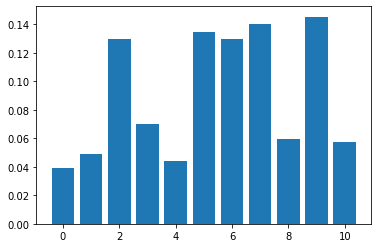

In [172]:
labels, hist = np.unique(y_train, return_counts=True)

plt.bar(labels, hist / np.sum(hist))

In [173]:
np.var(y_train), np.var(y_test)

(8.000566706021251, 7.936231267934955)

  0%|          | 0/30 [00:00<?, ?it/s]

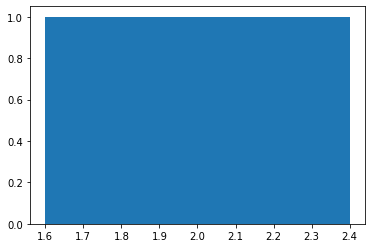

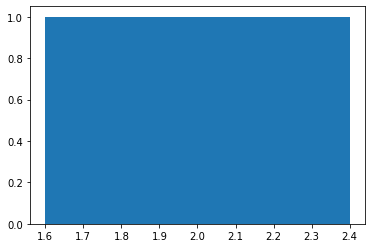

[Epoch 1] train loss: 2.368; acc_train 0.130; f1_train 0.021; test loss: 2.344; acc_test 0.124; f1_test 0.020;


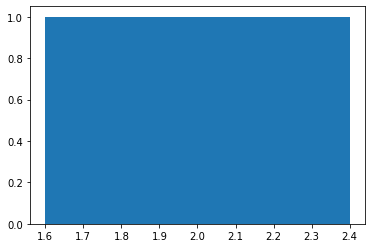

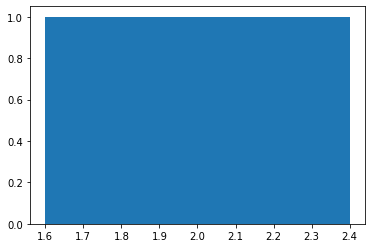

[Epoch 2] train loss: 2.340; acc_train 0.130; f1_train 0.021; test loss: 2.322; acc_test 0.124; f1_test 0.020;


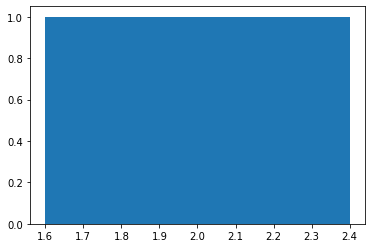

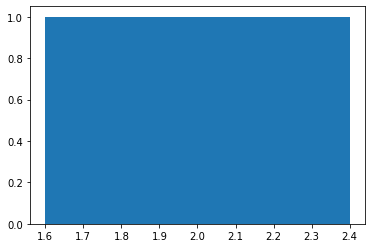

[Epoch 3] train loss: 2.323; acc_train 0.130; f1_train 0.021; test loss: 2.308; acc_test 0.124; f1_test 0.020;


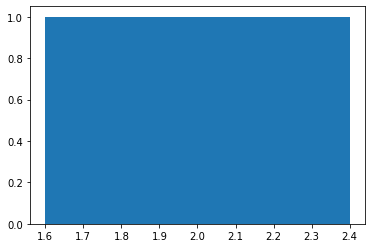

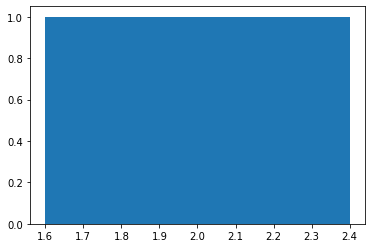

[Epoch 4] train loss: 2.308; acc_train 0.130; f1_train 0.021; test loss: 2.298; acc_test 0.124; f1_test 0.020;


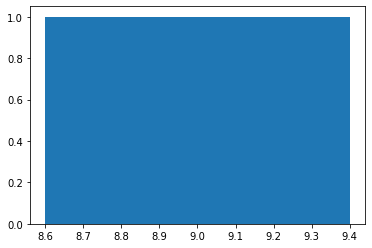

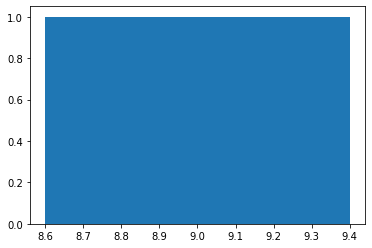

[Epoch 5] train loss: 2.303; acc_train 0.145; f1_train 0.023; test loss: 2.292; acc_test 0.144; f1_test 0.023;


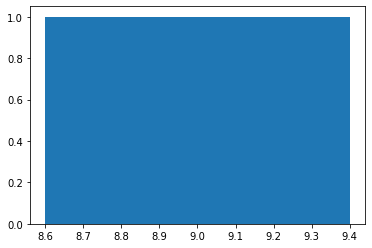

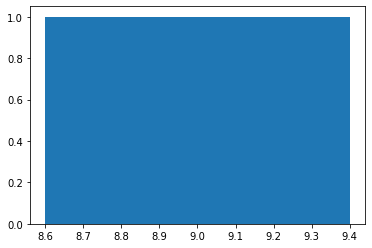

[Epoch 6] train loss: 2.301; acc_train 0.145; f1_train 0.023; test loss: 2.288; acc_test 0.144; f1_test 0.023;


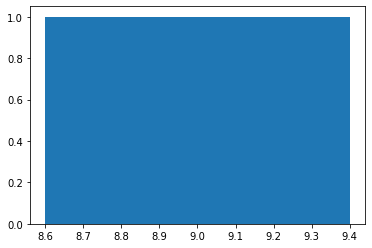

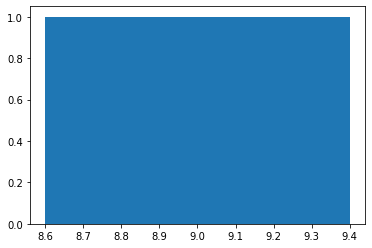

[Epoch 7] train loss: 2.302; acc_train 0.145; f1_train 0.023; test loss: 2.286; acc_test 0.144; f1_test 0.023;


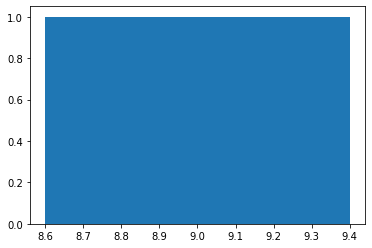

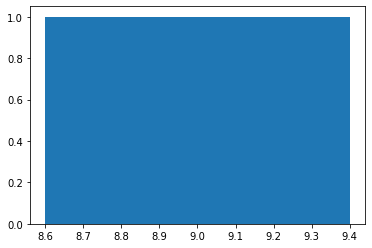

[Epoch 8] train loss: 2.298; acc_train 0.145; f1_train 0.023; test loss: 2.285; acc_test 0.144; f1_test 0.023;


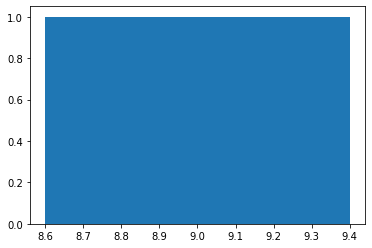

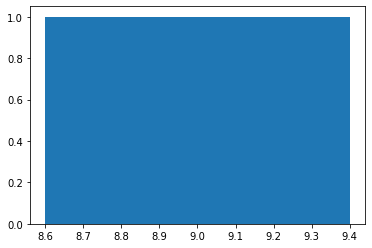

[Epoch 9] train loss: 2.300; acc_train 0.145; f1_train 0.023; test loss: 2.284; acc_test 0.144; f1_test 0.023;


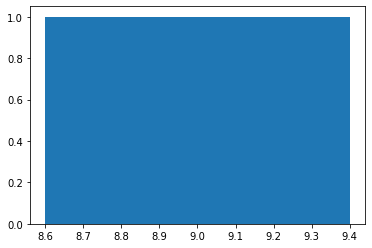

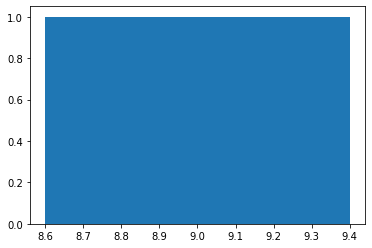

[Epoch 10] train loss: 2.294; acc_train 0.145; f1_train 0.023; test loss: 2.284; acc_test 0.144; f1_test 0.023;


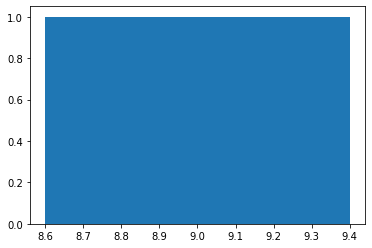

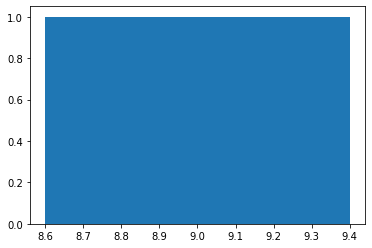

[Epoch 11] train loss: 2.290; acc_train 0.145; f1_train 0.023; test loss: 2.283; acc_test 0.144; f1_test 0.023;


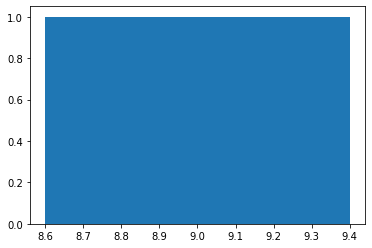

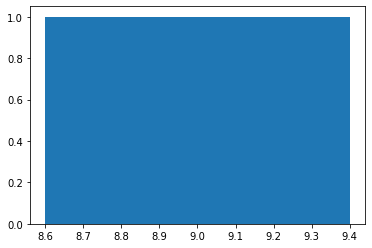

[Epoch 12] train loss: 2.293; acc_train 0.145; f1_train 0.023; test loss: 2.283; acc_test 0.144; f1_test 0.023;


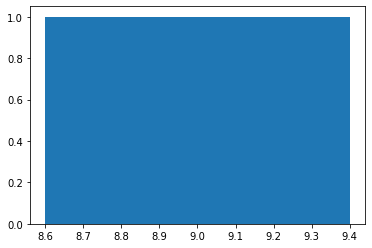

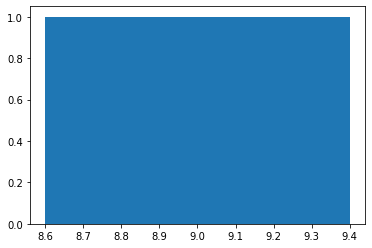

[Epoch 13] train loss: 2.295; acc_train 0.145; f1_train 0.023; test loss: 2.283; acc_test 0.144; f1_test 0.023;


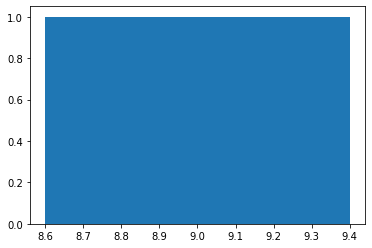

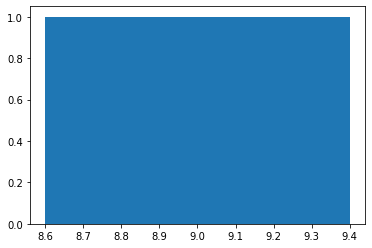

[Epoch 14] train loss: 2.294; acc_train 0.145; f1_train 0.023; test loss: 2.282; acc_test 0.144; f1_test 0.023;


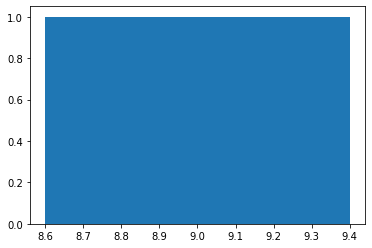

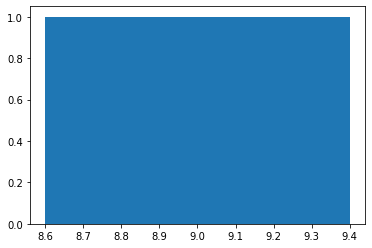

[Epoch 15] train loss: 2.290; acc_train 0.145; f1_train 0.023; test loss: 2.282; acc_test 0.144; f1_test 0.023;


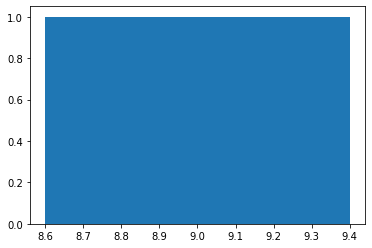

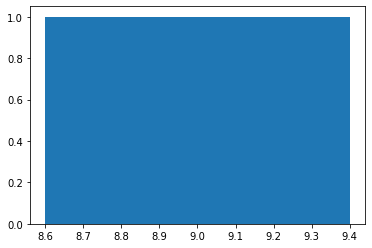

[Epoch 16] train loss: 2.291; acc_train 0.145; f1_train 0.023; test loss: 2.282; acc_test 0.144; f1_test 0.023;


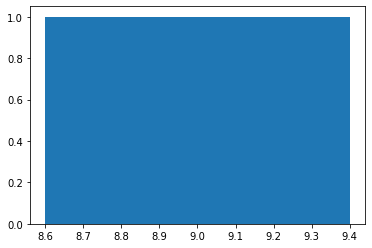

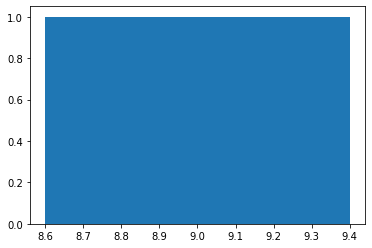

[Epoch 17] train loss: 2.292; acc_train 0.145; f1_train 0.023; test loss: 2.282; acc_test 0.144; f1_test 0.023;


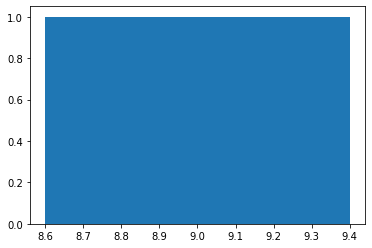

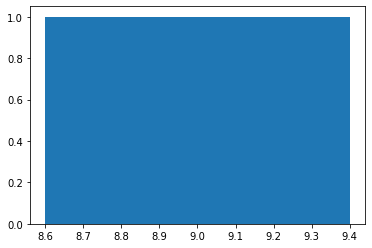

[Epoch 18] train loss: 2.292; acc_train 0.145; f1_train 0.023; test loss: 2.282; acc_test 0.144; f1_test 0.023;


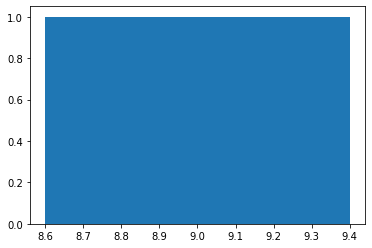

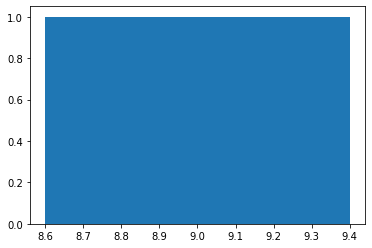

[Epoch 19] train loss: 2.293; acc_train 0.145; f1_train 0.023; test loss: 2.282; acc_test 0.144; f1_test 0.023;


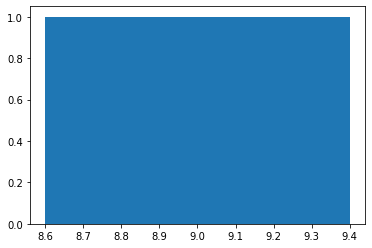

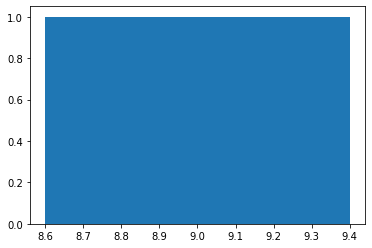

[Epoch 20] train loss: 2.291; acc_train 0.145; f1_train 0.023; test loss: 2.282; acc_test 0.144; f1_test 0.023;


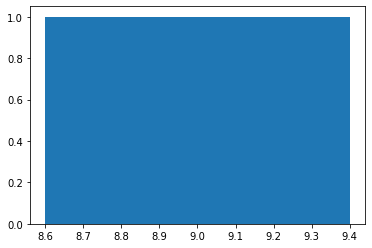

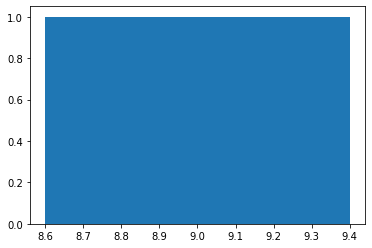

[Epoch 21] train loss: 2.296; acc_train 0.145; f1_train 0.023; test loss: 2.282; acc_test 0.144; f1_test 0.023;


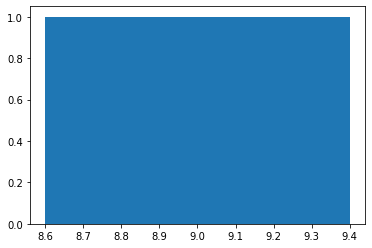

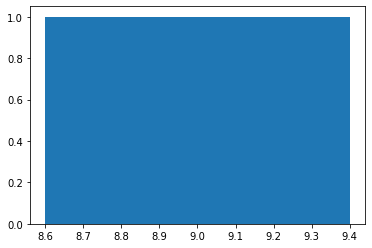

[Epoch 22] train loss: 2.290; acc_train 0.145; f1_train 0.023; test loss: 2.282; acc_test 0.144; f1_test 0.023;


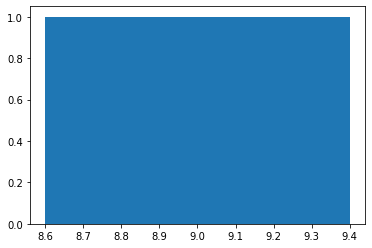

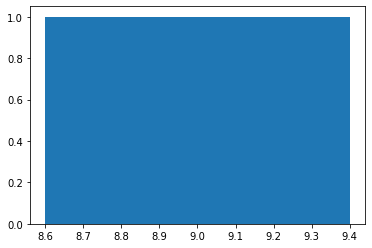

[Epoch 23] train loss: 2.293; acc_train 0.145; f1_train 0.023; test loss: 2.282; acc_test 0.144; f1_test 0.023;


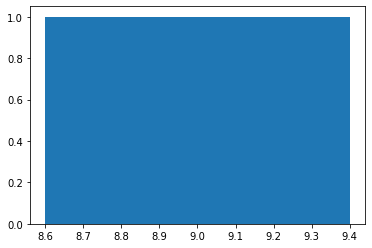

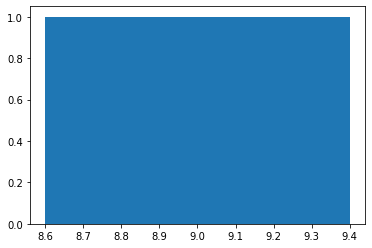

[Epoch 24] train loss: 2.289; acc_train 0.145; f1_train 0.023; test loss: 2.282; acc_test 0.144; f1_test 0.023;


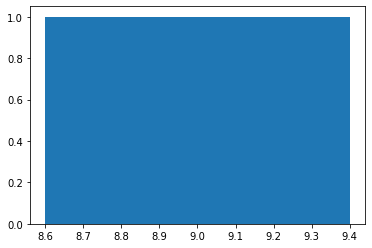

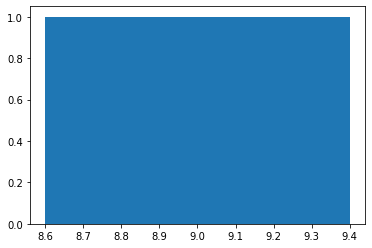

[Epoch 25] train loss: 2.290; acc_train 0.145; f1_train 0.023; test loss: 2.282; acc_test 0.144; f1_test 0.023;


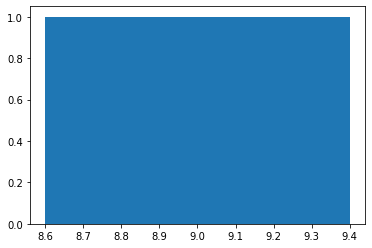

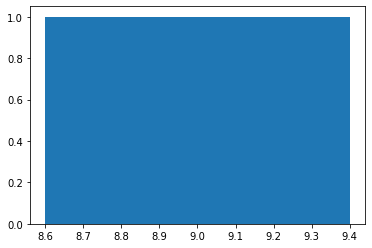

[Epoch 26] train loss: 2.286; acc_train 0.145; f1_train 0.023; test loss: 2.282; acc_test 0.144; f1_test 0.023;


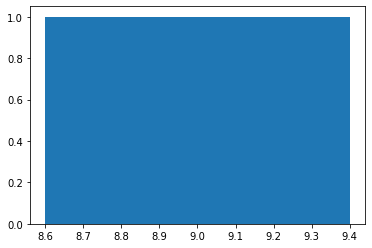

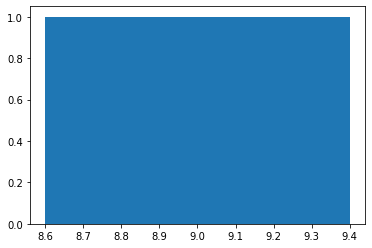

[Epoch 27] train loss: 2.290; acc_train 0.145; f1_train 0.023; test loss: 2.282; acc_test 0.144; f1_test 0.023;


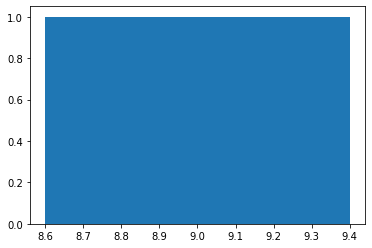

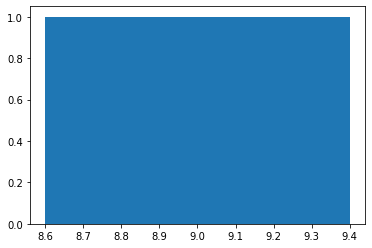

[Epoch 28] train loss: 2.293; acc_train 0.145; f1_train 0.023; test loss: 2.282; acc_test 0.144; f1_test 0.023;


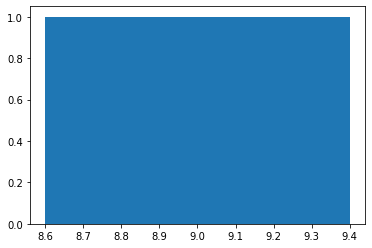

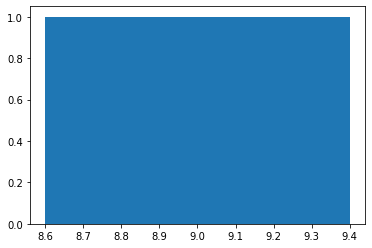

[Epoch 29] train loss: 2.295; acc_train 0.145; f1_train 0.023; test loss: 2.282; acc_test 0.144; f1_test 0.023;


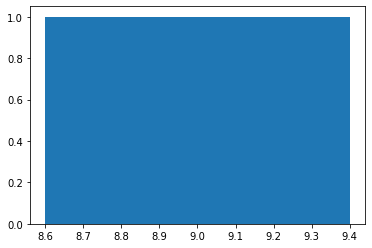

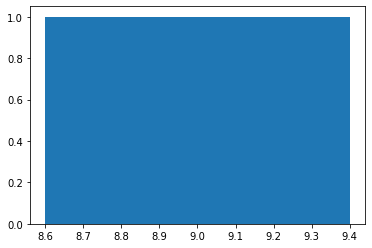

[Epoch 30] train loss: 2.291; acc_train 0.145; f1_train 0.023; test loss: 2.282; acc_test 0.144; f1_test 0.023;


In [174]:
model = train_procedure(model, train_loader, test_loader, criterion, optimizer,
                num_epochs=num_epochs, step_print=1)

In [ ]:
batch = next(iter(train_loader))
batch[0].shape

In [96]:
torch.dtype

torch.dtype